# Counterfactual Data Substitution (CDS)
# this was done within doc, not per-document because I misunderstood the theory. It is fixed in the version with the suffix _new

## Imports

In [2]:
# set cwd
import os
os.chdir("g:\\My Drive\\ITC, 5th semester (Thesis)\\Code\\Github_code\\toxicity_detection")

# imports
import pandas as pd
import random
from collections import Counter
import matplotlib.pyplot as plt
from string import punctuation
# import spacy
from spacy import displacy
from tqdm import tqdm
from utils import load_dkhate
from typing import Dict
import pickle
import dacy
import utils
import nltk
import re
import string

c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

In [3]:
def add_pos_tags(text:str) -> str:
    """Add POS-tags to text (format: "my_DET example_NOUN").

    Args:
        text (str): text without POS-tags

    Returns:
        str: text with POS-tags
    """
    tokens_with_pos = []
    for token in nlp(text):
        tokens_with_pos.append(f"{token}_{token.pos_}")
    return " ".join(tokens_with_pos)

def add_pos_with_context(series:pd.Series, pre_context:str, post_context:str="") -> pd.Series:
    """Add POS tags to text in series. The tags are assigned based on the word's role in the provided context.

    Args:
        series (pd.Series): the series of text without POS tags
        pre_context (str): the sentence before the word from the series, e.g. "He gave" if the context is: "He gave {word} to her".
        post_context (str, optional): the sentence after the word, e.g. "to her" if the context is: "He gave {word} to her". Defaults to "".

    Returns:
        pd.Series: the series of text with POS tags
    """
    res = [] # store results
    text_idx = len(pre_context.split()) # text is located after pre_context
    for text in series:
        text = text.lower()
        text_with_tags = add_pos_tags(pre_context + " " + text + " " + post_context).split()
        res.append(" ".join( text_with_tags[ text_idx : text_idx+len(text.split()) ] ))
    return pd.Series(res)

def remove_pos_tags(text:str) -> str:
    """Remove POS-tags from text (e.g.: "example_NOUN" -> "example").

    Args:
        text (str): text with POS-tags, e.g. "my_DET example_NOUN"

    Returns:
        str: text without POS-tags, e.g. "my example"
    """
    pattern = re.compile(r"_([A-Z]+)\b")
    return pattern.sub("", text)

def remove_punctuation(string:str) -> str:
    """Remove punctuation from a string.
    
    Args: 
        string (str): string with punctuation
    
    Returns:
        str: string without punctuation
    """
    return string.translate(str.maketrans("", "", punctuation))

def pick_substitution(orig_word:str, gender_triplet:Dict[str, str]) -> str:
    """If the word is in the gender dictionary, find a word to substitute it with (either itself or one of the two other gender categories).

    Args:
        orig_word (str): the original word.
        gender_dict (Dict[str, str]): dictionary of the gender triplets, i.e. {female: female_word, male: male_word, queer: queer_word}

    Returns:
        str: the new word.
    """
    if any(gender_word == orig_word for gender_word in gender_triplet.values()): # if the current word appears in the gender triplet
        rd_substitution = random.choice(["female", "male", "queer"]) # pick a random gender to substitute it with
        new_word = gender_triplet[rd_substitution] # pick any of the three words to substitute it with
        return new_word
    else:
        return None

## Load DaCy model

In [4]:
# load daCy model (medium works fine)
nlp = dacy.load("da_dacy_medium_trf-0.2.0") # takes around 4 minutes the first time

# test that it works as expected 
doc = nlp("Mit navn er Maja. Jeg bor på Bispebjerg, men er fra Næstved.") 
print("POS tags:")
for tok in doc: 
    print(f"{tok}:\t\t {tok.pos_}\t\t {tok.ent_type_}")
displacy.render(doc, style="ent")

POS tags:
Mit:		 DET		 
navn:		 NOUN		 
er:		 AUX		 
Maja:		 PROPN		 PER
.:		 PUNCT		 
Jeg:		 PRON		 
bor:		 VERB		 
på:		 ADP		 
Bispebjerg:		 PROPN		 LOC
,:		 PUNCT		 
men:		 CCONJ		 
er:		 VERB		 
fra:		 ADP		 
Næstved:		 PROPN		 LOC
.:		 PUNCT		 


## Gender triplet dictionary

In [5]:
# load gender triplet dictionary from excel-file
gender_df = pd.read_excel(os.getcwd()+"\\mitigation\\gender_triplet_dict_new.xlsx")
gender_dict = gender_df.to_dict(orient="index")

# inspect format
for i in range(5):
    print(gender_dict[i])

{'female': 'hun', 'male': 'han', 'queer': 'hen'}
{'female': 'hende', 'male': 'ham', 'queer': 'hem'}
{'female': 'hendes', 'male': 'hans', 'queer': 'hens'}
{'female': 'abbedisse', 'male': 'abbed', 'queer': 'KtM'}
{'female': 'abbedissen', 'male': 'abbeden', 'queer': "KtM'en"}


In [6]:
# add POS tags to triplet dict

# split dict into pronouns, singular and plural words
gender_df_pron = gender_df.iloc[0:3, :] # pronouns
gender_df_sg = gender_df.iloc[3::2, :] # sg 
gender_df_pl = gender_df.iloc[4::2, :] # pl 

# add POS tags to PRONOUNS
nom = add_pos_with_context(gender_df_pron.iloc[0,:], "Moren fortæller ,", "er træt af skolen.")
acc = add_pos_with_context(gender_df_pron.iloc[1,:], "Nor giver", "en gave.")
gen = add_pos_with_context(gender_df_pron.iloc[2,:], "Nor modtog", "pakke.")
gender_df_pron_POS = pd.DataFrame([nom, acc, gen])

# add POS tags to SINGULAR words
gender_df_sg_POS_f = add_pos_with_context(gender_df_sg["female"], "Nor er en")
gender_df_sg_POS_m = add_pos_with_context(gender_df_sg["male"], "Nor er en")
gender_df_sg_POS_q = add_pos_with_context(gender_df_sg["queer"], "Nor er en")
gender_df_sg_POS = pd.DataFrame([gender_df_sg_POS_f, gender_df_sg_POS_m, gender_df_sg_POS_q]).T

# add POS tags to PLURAL words
gender_df_pl_POS_f = add_pos_with_context(gender_df_pl["female"], "Alle Nors venner er")
gender_df_pl_POS_m = add_pos_with_context(gender_df_pl["male"], "Alle Nors venner er")
gender_df_pl_POS_q = add_pos_with_context(gender_df_pl["queer"], "Alle Nors venner er")
gender_df_pl_POS = pd.DataFrame([gender_df_pl_POS_f, gender_df_pl_POS_m, gender_df_pl_POS_q]).T

In [6]:
# # inspect results
# display(gender_df_sg_POS)
# display(gender_df_pl_POS)
# display(gender_df_pron_POS)

In [7]:
# concatenate dataframes
gender_df_with_POS = pd.concat([gender_df_pron_POS, gender_df_sg_POS, gender_df_pl_POS]).reset_index(drop=True) # reset index to avoid duplicate indexes
gender_df_with_POS.columns = ["female", "male", "queer"] # rename columns
gender_dict_with_POS = gender_df_with_POS.to_dict(orient="index") # convert to dictionary
print(len(gender_dict_with_POS), "gender triplets.")

197 gender triplets.


## Load data splits

In [8]:
# # check randomness of random.choice
# storage = [random.choice(["female", "male", "queer"]) for i in range(1000)]

# plt.figure(figsize=(3,3))
# plt.pie(dict(Counter(storage)).values(), labels=dict(Counter(storage)).keys(), autopct='%1.1f%%')
# plt.title("Random choice (1000 iterations)")
# plt.plot();

In [8]:
# load train and test splits
X_train_orig, X_test_orig, y_train_orig, y_test_orig = load_dkhate(test_size=0.2)
train_orig = pd.DataFrame([X_train_orig, y_train_orig]).T
train_orig.tail()

,tweet,label
id,,
2378,Hørt!,0
1879,Min reaktion hvis jeg var Svensker,0
42,hey champ Vil du ikke smide et link til hvor d...,0
457,Hvis du melder en for vold eller voldtægt og d...,1
3108,"Vi betaler for omkring 4mb ned, 500kb op men f...",0


## Perform CDS
Takes approx. 10 minutes to run.

In [10]:
# example of within-document name anonymization 
# Larsen should be given the same tag within documents, but different tags across documents (same for Kim)

ex = pd.DataFrame(["En sætning om Kim Larsen. Det er sandt, at Kim elsker kaffe.", "Nu handler det om Kim Petras", "Hr. Larsen giver fru Larsen en buket blomster én gang om året.", "!!!"], columns=["text"])

names_counter = 0

for text in ex["text"]:
    
    # anonymize names and add POS tags
    name_anonymous_dict = {}
    text = remove_punctuation(text.lower())
    text_pos = "" #text with POS-tags
    if len(text) > 0: 
        print(text)
        doc = nlp(text)
        for token in doc:
            token_str = str(token)
            if token.ent_type_ == "PER":
                
                if token_str not in name_anonymous_dict:
                    names_counter += 1
                    name_anonymous_dict[token_str] = "E"+str(names_counter)
                token_str = name_anonymous_dict[token_str] 
                print(f"   {str(token).ljust(7)} →  {token_str}")
                # print(token, token.pos_, token_str)
                # text_pos += " "+token_str+"_PROPN" # manually assign POS-tag as it's a string, not token object
            text_pos += f" {token_str}_{token.pos_}" 
    print()

en sætning om kim larsen det er sandt at kim elsker kaffe
   kim     →  E1
   larsen  →  E2
   kim     →  E1

nu handler det om kim petras
   kim     →  E3
   petras  →  E4

hr larsen giver fru larsen en buket blomster én gang om året
   larsen  →  E5
   larsen  →  E5




In [11]:
# initialize variables
new_train_X = [] # for storing new training data
names_counter = 0 # count unique names
names = [] # store all names
new_nouns = [] # store new nouns
old_nouns = [] # store old nouns

for text in tqdm(train_orig["tweet"]):   
    name_anonymous_dict = dict() # store anonymization tags

    # 1) remove punctuation and lowercase
    text = remove_punctuation(text.lower())
    text_w_pos = "" # text with pos-tags
    
    if len(text) > 0: # if string not empty (else, an empty string is added to text_w_pos at the end)
        doc = nlp(text)
        for token in doc:
            token_str = str(token) # string version of token
            
            # 2) anonymize the names in the text and add POS tags 
            if token.ent_type_ == "PER":
                if token_str not in name_anonymous_dict: # if not already in dict, add it
                    names_counter += 1
                    name_anonymous_dict[token_str] = "E"+str(names_counter)
                token_str = name_anonymous_dict[token_str] # make substitution
                names.append(token_str)
            token_w_pos = f"{token_str}_{token.pos_}"
            text_w_pos += " "+token_w_pos
            
            # 3) substitute the gendered words with other gendered words
            for idx in gender_dict_with_POS:
                new_word = pick_substitution(token_w_pos, gender_dict_with_POS[idx])
                if new_word is not None: # i.e. if substitution should be performed
                    text_w_pos = text_w_pos.replace(token_w_pos, new_word)
                    old_nouns.append(token_w_pos)
                    new_nouns.append(new_word)
            
            # 4) remove pos tag
            text_wo_pos = remove_pos_tags(text_w_pos)
    
    new_train_X.append(text_wo_pos)

100%|██████████| 2631/2631 [06:53<00:00,  6.37it/s] 


In [12]:
# convert to series
X_train_CDS = pd.Series(new_train_X)

# check shapes
print(X_train_orig.shape)
print(X_train_CDS.shape)
assert X_train_orig.shape == X_train_CDS.shape

display(X_train_CDS.head())

(2631,)
(2631,)


0                                               hahaha
1     user hvis du føler du har det svært så prøv a...
2      det er endnu en barriere for bønder uden for eu
3     mit eneste møde ved hem var på min snuskede s...
4     forøvrigt taget fra et godt dokumentarprogram...
dtype: object

## Inspect changes

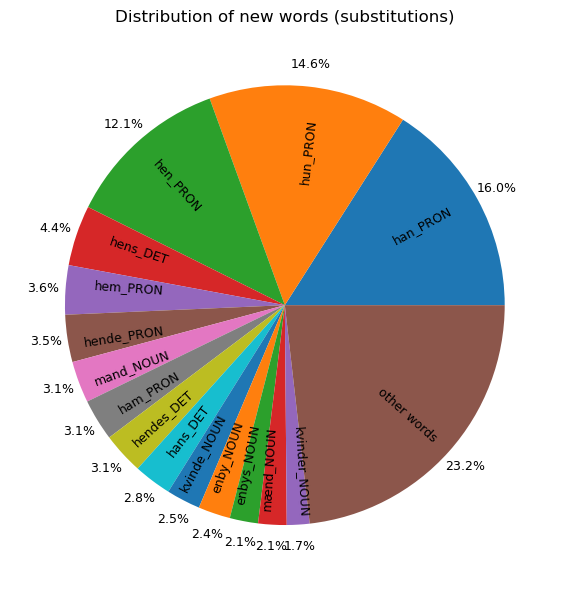

In [13]:
# distribution of new words (substitutions)
c = Counter(new_nouns).most_common() # sorted in descending order
c = pd.DataFrame(c, columns=["word", "count"]) # as df
most_freq = c[:15] # top-15 most frequent substitutions
other = pd.DataFrame(
    data={"word": ["other words"], "count": [c[15:]["count"].sum()]}, 
    index=[15]) # create other category
c = pd.concat([most_freq, other])

plt.figure(figsize=(6,6))
plt.pie(c["count"], labels=c["word"], autopct='%1.1f%%', rotatelabels=True, textprops={'fontsize': 9}, pctdistance=1.1, labeldistance=0.55)
plt.title("Distribution of new words (substitutions)")
plt.tight_layout()
plt.plot();

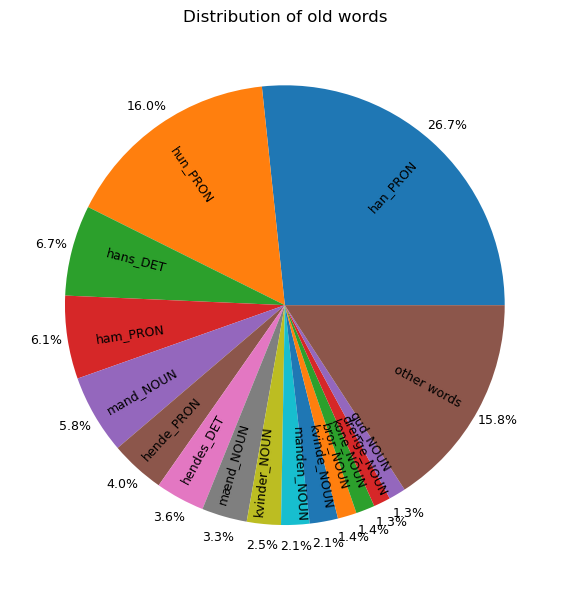

In [14]:
# distribution of old words
c = Counter(old_nouns).most_common() # sorted in descending order
c = pd.DataFrame(c, columns=["word", "count"]) # as df
most_freq = c[:15] # top-15 most frequent substitutions
other = pd.DataFrame(
    data={"word": ["other words"], "count": [c[15:]["count"].sum()]}, 
    index=[15]) # create other category
c = pd.concat([most_freq, other])

plt.figure(figsize=(6,6))
plt.pie(c["count"], labels=c["word"], autopct='%1.1f%%', rotatelabels=True, textprops={'fontsize': 9}, pctdistance=1.1, labeldistance=0.55)
plt.title("Distribution of old words")
plt.tight_layout()
plt.plot();

In [15]:
# which names were replaced?
for k in name_anonymous_dict.keys():
    print(k)

## Save new training set

In [16]:
# save the new training set
train_new = pd.DataFrame(zip(new_train_X, y_train_orig), columns=["text", "label"])

# pickle
with open("data/train_CDS.pkl", "wb") as f:
    pickle.dump({"train":train_new,
                 "X":new_train_X,
                 "y":y_train_orig}, f)

In [17]:
# inspect before and after
print("Before CDS {}:".format(train_orig.shape))
display(train_orig.head(10))

print("\nAfter CDS {}:".format(train_new.shape))
display(train_new.head(10))

Before CDS (2631, 2):


,tweet,label
id,,
3176,Hahaha,0
1440,@USER hvis du føler du har det svært så prøv a...,0
3501,Det er endnu en barriere for bønder uden for E...,0
3016,Mit eneste møde ved ham var på min snuskede st...,0
2399,Forøvrigt taget fra et godt dokumentarprogram ...,0
3526,Plagiat :') URL,0
2029,###Vi tager vores gamle kongerige tilbage med ...,0
479,@USER Der er altså heller ikk noget værre end ...,0
250,Læs statistikker.. så har du svaret på dit spø...,0



After CDS (2631, 2):


,text,label
0,hahaha,0
1,user hvis du føler du har det svært så prøv a...,0
2,det er endnu en barriere for bønder uden for eu,0
3,mit eneste møde ved hem var på min snuskede s...,0
4,forøvrigt taget fra et godt dokumentarprogram...,0
5,plagiat url,0
6,vi tager vores gamle kongerige tilbage med co...,0
7,user der er altså heller ikk noget værre end ...,0
8,læs statistikker så har du svaret på dit spør...,0
9,jeg mener at dfs ideologi har klare nazistisk...,0


In [18]:
# # sanity check grammaticality of new sentences
# for t in train_new[train_new['label']==1]['text'][:10]:
#     print(t)
#     print()